# Adding a problem to pySDC

In this notebook, we will implement a simple advection-diffusion equation $$u_t = f(u) = \nu u_{xx} + cu_x$$ with periodic boundary conditions using finite differences.
Let's have a look at the math that we need to implement in order to integrate this with SDC.

The SDC iteration is $$(1-\Delta t \tilde{q}_{m+1,m+1} f)(u_{m+1}^{k+1}) = u_0 + \Delta t \sum_{j=1}^m \tilde{q}_{m+1, j} f(u_{j}^{k+1}) -\Delta t \sum_{j=1}^{m+1}\tilde{q}_{m+1,j} f(u_{j}^{k}) + \Delta t \sum_{j=1}^M q_{m+1, j} (f)(u_{j}^k), \quad m = 0, \dots, M-1,$$ where $q_{ij}$ and $\tilde{q}_{ij}$ are the entries of the quadrature matrix and preconditioner respectively.
The right hand side is a weighted sum of evaluations of $f$ with solutions at various collocation nodes and iterations and the left hand side is essentially an implicit Euler step with step size modified by the preconditioner.
Therefore, the only math we need to implement in the problem class is **evaluating $f$** and **solving implicit Euler steps**.

Keep in mind that you can use an explicit preconditioner, in which case you don't even need the implicit Euler solves, but explicit SDC is rarely useful.
If implementing an implicit Euler step for your problem is too difficult, consider splitting off difficult terms and integrating them explicitly or designing a novel SDC scheme.
The iterative nature of SDC allows a lot of freedom which is one of the key advantages of SDC.

## Evaluating $f$

In finite difference discretizations, we compute derivatives by multiplying matrices with a vector of solution values at the grid points.
In pySDC we have some infrastructure for generating finite difference matrices, making this very easy to implement.

We generate one matrix for the advection part, i.e. the first derivative, and one matrix for the diffusion part (the second derivative).
The $f$ evaluation is then a weighted sum of the matrices multiplied by the solution vector.

In [1]:
import numpy as np
from pySDC.helpers.problem_helper import get_finite_difference_matrix, get_1d_grid

# problem parameters
nu = 1e-3
c = 1e-1
N = 128

# setup grid
dx, grid = get_1d_grid(size=N, bc='periodic', left_boundary=0, right_boundary=2 * np.pi)

# setup finite difference matrices
fd_params = {'order': 4, 'stencil_type': 'center', 'dx': dx, 'size': N, 'dim': 1, 'bc': 'periodic'}
advection, _ = get_finite_difference_matrix(derivative=1, **fd_params)
diffusion, _ = get_finite_difference_matrix(derivative=2, **fd_params)


def eval_f(u):
    return (c * advection + nu * diffusion) @ u

Before moving on, we briefly verify that we did the correct thing by comparing the numerical derivatives to exact ones for a simple sine wave:

In [2]:
u = np.sin(grid)
assert np.allclose(diffusion @ u, -np.sin(grid))  # check diffusion part
assert np.allclose(advection @ u, np.cos(grid))  # check advection part
assert np.allclose(eval_f(u), -nu * np.sin(grid) + c * np.cos(grid))  # check f evaluation

## Implicit Euler step

In the implicit Euler step, we solve $(1-\Delta t f)(u) = y$, where $y$ is some arbitrary right hand side. We use a simple direct solver and the matrices we used to evaluate $f$ here:

In [3]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import eye


def implicit_euler(rhs, dt):
    A = eye(N) - dt * (c * advection + nu * diffusion)
    return spsolve(A, rhs)

Let's once again verify the implementation. This time, we will compare to exact solutions for either the diffusion or the advection equation, which we obtain by setting the $c$ or $\nu$ parameters to 0.

In [4]:
u = np.sin(grid)
dt = 1e-2

# check advection
nu = 0
c = 1e-1
assert np.allclose(implicit_euler(u, dt), np.sin(grid + c * dt))

# check diffusion
nu = 1e-1
c = 0
assert np.allclose(implicit_euler(u, dt), np.sin(grid) * np.exp(-nu * dt))

## Implementing this class in pySDC

So far, we have looked at what math you need to implement in order to do SDC with your problem, now we will set up a class with the same functionality that we can then hand to pySDC to actually run SDC.

Here, it is important to use the interface defined in the sweeper classes, which take care of the actual time integration.
Also, we need to add some infrastructure for generating empty data containers, and we add some work counters for analysis later on.
But you will find that the implementation in pySDC is not significantly more complicated or convoluted than what we did before.

In [5]:
from pySDC.core.problem import Problem, WorkCounter
from pySDC.implementations.datatype_classes.mesh import mesh
import scipy.sparse as sp
import numpy as np


class AdvectionDiffusion(Problem):
    dtype_u = mesh  # wraps numpy ndarray
    dtype_f = mesh

    def __init__(self, N, c, nu):
        init = (N, None, np.dtype('float64'))  # describes how to initialize data
        super().__init__(init=init)

        # setup grid
        dx, self.grid = get_1d_grid(size=N, bc='periodic', left_boundary=0, right_boundary=2 * np.pi)

        # setup finite difference matrices
        fd_params = {'order': 4, 'stencil_type': 'center', 'dx': dx, 'size': N, 'dim': 1, 'bc': 'periodic'}
        advection, _ = get_finite_difference_matrix(derivative=1, **fd_params)
        diffusion, _ = get_finite_difference_matrix(derivative=2, **fd_params)

        # setup matrices used in eval_f and implicit solves
        self.A = c * advection + nu * diffusion
        self.Id = sp.eye(N)

        # store attributes and register them as parameters
        self._makeAttributeAndRegister('N', 'c', 'nu', localVars=locals(), readOnly=True)

        # set up counters
        self.work_counters['eval_f'] = WorkCounter()

    def eval_f(self, u, t):
        self.work_counters['eval_f']()  # increment counter
        me = self.f_init  # get empty data container
        me[...] = self.A @ u
        return me

    # the implicit Euler step is called solve_system here because it could be sth. else in a different SDC scheme
    # u0 is the initial guess for the solver
    def solve_system(self, rhs, dt, u0, t):
        me = self.u_init

        # prepare a new work counter for this factor / step size. Seems weird now, but bear with me.
        key = f'gmres-{dt:.2e}'
        self.work_counters[f'gmres-{dt:.2e}'] = self.work_counters.get(key, WorkCounter())

        me[...], _ = sp.linalg.gmres(
            self.Id - dt * self.A, rhs, x0=u0, callback=self.work_counters[key], rtol=1e-10, callback_type='pr_norm'
        )
        return me

    def u0(self):
        me = self.u_init
        me[...] = np.sin(self.grid)
        return me

Let's do the same tests once more.
Note that the pySDC `mesh` datatype has a different `abs` function than `numpy.ndarray`.

In [6]:
prob = AdvectionDiffusion(128, 1e-1, 1e-3)
u = prob.u0()
assert np.allclose(prob.eval_f(u, 0), -prob.nu * np.sin(prob.grid) + prob.c * np.cos(prob.grid))

dt = 1e-2
advection_prob = AdvectionDiffusion(N=128, c=1e-1, nu=0)
u = advection_prob.u0()
assert abs(advection_prob.solve_system(u, dt, u, 0) - np.sin(advection_prob.grid + advection_prob.c * dt)) < 1e-6

diffusion_prob = AdvectionDiffusion(N=128, c=0, nu=1e-1)
u = diffusion_prob.u0()
assert (
    abs(diffusion_prob.solve_system(u, dt, u, 0) - np.sin(diffusion_prob.grid) * np.exp(-diffusion_prob.nu * dt)) < 1e-6
)

Looks good!
Now let's set up pySDC to integrate this problem with SDC.

## Running with pySDC

We will do small scale time-parallelism by choosing a diagonal preconditioner called [MIN-SR-S](https://arxiv.org/abs/2403.18641).
Since we are running this in a notebook, we will resort to counting iterations rather than measuring run time and use serial implementations of everything.
SDC has a vast parameter space and we need to supply loads of parameters here.
Don't worry too much about them for now.

In [7]:
from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.implementations.hooks.log_solution import LogSolution
from pySDC.implementations.hooks.log_work import LogWork

# level and step parameters contain general parameters such as how many SDC iterations will be done
level_params = {}
level_params['dt'] = 1e-1
level_params['restol'] = 1e-8

step_params = {}
step_params['maxiter'] = 9

# the sweeper parameters describe the collocation problem and the preconditioner
sweeper_params = {}
sweeper_params['quad_type'] = 'RADAU-RIGHT'
sweeper_params['num_nodes'] = 3
sweeper_params['QI'] = 'MIN-SR-S'

problem_params = {
    'N': 128,
    'c': 8e-1,
    'nu': 1e-1,
}

# gather all parameters in one dictionary and add problem and sweeper class
description = {}
description['problem_class'] = AdvectionDiffusion
description['problem_params'] = problem_params
description['sweeper_class'] = generic_implicit
description['sweeper_params'] = sweeper_params
description['level_params'] = level_params
description['step_params'] = step_params

# more parameters for the controller
controller_params = {}
controller_params['logger_level'] = 15
controller_params['hook_class'] = [LogSolution, LogWork]

# setup controller
controller = controller_nonMPI(controller_params=controller_params, description=description, num_procs=1)

controller - INFO: Welcome to the one and only, really very astonishing and 87.3% bug free
                                 _____ _____   _____ 
                                / ____|  __ \ / ____|
                    _ __  _   _| (___ | |  | | |     
                   | '_ \| | | |\___ \| |  | | |     
                   | |_) | |_| |____) | |__| | |____ 
                   | .__/ \__, |_____/|_____/ \_____|
                   | |     __/ |                     
                   |_|    |___/                      
                                                     
controller - INFO: Setup overview (--> user-defined, -> dependency) -- BEGIN
controller - INFO: ----------------------------------------------------------------------------------------------------

Controller: <class 'pySDC.implementations.controller_classes.controller_nonMPI.controller_nonMPI'>
    all_to_done = False
    dump_setup = True
    fname = run_pid94051.log
--> hook_class = [<class 'pySDC.implementations.hoo

Above, we see all the configuration that we have passed to the controller.
`-->` indicates that we have manually set this parameter, while other parameters are left at their default value.

Now that we have a pySDC controller, we set up some initial conditions and run

In [8]:
# get initial conditions
P = controller.MS[0].levels[0].prob
uinit = P.u0()

uend, stats = controller.run(u0=uinit, t0=0, Tend=1)

hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.31471144e-04
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 6.32549457e-06
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.48579940e-07
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  4 -- Sweep:  1 -- residual: 3.29160453e-09
hooks - INFO: Process  0 on time 0.100000 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.30153942e-04
hooks - INFO: Process  0 on time 0.100000 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 6.26183780e-06
hooks - INFO: Process  0 on time 0.100000 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.47216986e-07
hooks - INFO: Process  0 on time 0.100000 at stage     

Above we see very high-level information about what has happened.
We can monitor the decrease of the residual of the collocation problem and see that in all steps it was below our desired tolerance after 4 SDC iterations.

## Analysing a pySDC run

The controller returned two things: The solution at the end of the run and a dictionary containing a lot of statistics.
Let's first inspect what sort of data we have available in `stats`.

In [9]:
from pySDC.helpers.stats_helper import get_list_of_types

print(get_list_of_types(stats))

['residual_post_sweep', 'residual_post_iteration', 'niter', 'residual_post_step', '_recomputed', 'timing_setup', 'timing_comm', 'timing_sweep', 'timing_iteration', 'timing_step', 'timing_run', 'u', 'work_eval_f', 'work_gmres-1.04e-02', 'work_gmres-3.33e-02', 'work_gmres-4.81e-02', 'restart']


Things like residuals and timings are automatically recorded, but others are recorded because we supplied certain hooks.
In this case, we specified to log the solution and the work.
The results are called `u`, `work_gmres-[...]`, and `work_eval_f` here.
The latter are generated from the work counters that we set up in the problem class.

Let's start by looking at how the solution has evolved.
We use the `get_sorted` function to sort the solution values by time.
This function returns a list in which the values are tuples of the key we sorted by and the value itself.

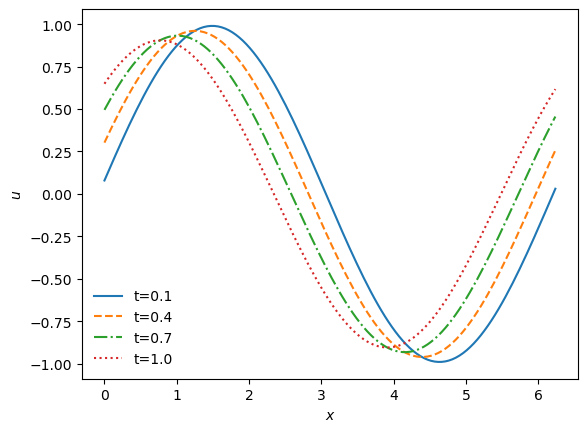

In [10]:
from pySDC.helpers.stats_helper import get_sorted
import matplotlib.pyplot as plt

u = get_sorted(stats, type='u', sortby='time')
for i, ls in zip([0, 3, 6, 9], ['-', '--', '-.', ':']):
    plt.plot(P.grid, u[i][1], label=f't={u[i][0]:.1f}', ls=ls)
plt.legend(frameon=False)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.show()

As time progresses, the solution moves to the left and decays, just like we expected.

So, let's look at something more interesting: What is the speedup that we got from the diagonal preconditioner?
Diagonal preconditioners allow to distribute the implicit Euler steps and right hand side evaluations, which make up the bulk of computational cost, among as many tasks as we have nodes, which is 3 in our case.
So, neglecting communication cost, we get a speedup of 3, right?
Well, no.
We use an iterative solver for the linear systems in `solve_system`, which may need a different number of iterations depending on the step size for the implicit Euler step.
Eariler, we strangely set up individual counters for each step size, but now we can use this to estimate speedup.

Performed 45% of GMRES iterations on task 2. This translates to speedup of 2.25 and 75% parallel efficiency in the implicit solves.


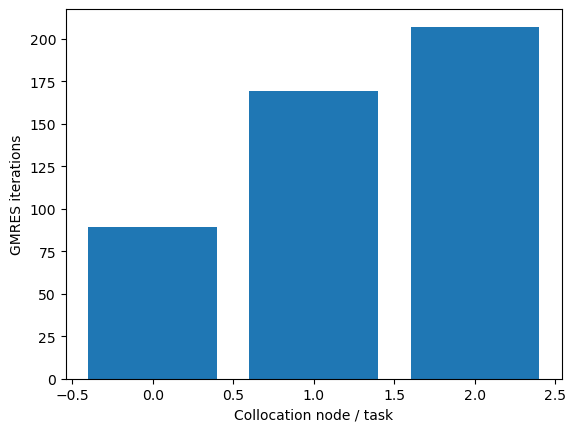

In [11]:
# get values on the diagonal of the preconditioner
sweeper = controller.MS[0].levels[0].sweep
diag_vals = [sweeper.QI[i + 1, i + 1] for i in range(sweeper.coll.num_nodes)]

# get the keys for gmres iterations at various step sizes from this
work_keys = [f'work_gmres-{sweeper.level.dt * me:.2e}' for me in diag_vals]

# compute the total number of gmres iterations per task
gmres_iter_per_task = [sum(me[1] for me in get_sorted(stats, type=key)) for key in work_keys]
total_gmres_iterations = sum(gmres_iter_per_task)

# compute speedup in implicit solves
max_rel_gmres_per_task = max(gmres_iter_per_task) / total_gmres_iterations
speedup = 1 / max_rel_gmres_per_task
parallel_efficiency = speedup / sweeper.coll.num_nodes

# visualize and print the results
import matplotlib.pyplot as plt

plt.bar(np.arange(sweeper.coll.num_nodes), gmres_iter_per_task)
plt.ylabel('GMRES iterations')
plt.xlabel('Collocation node / task')

print(
    f'Performed {max_rel_gmres_per_task*100:.0f}% of GMRES iterations on task {np.argmax(gmres_iter_per_task)}. This translates to speedup of {speedup:.2f} and {parallel_efficiency*100:.0f}% parallel efficiency in the implicit solves.'
)

We see that we have some load balancing issues here that prevent perfect scaling even without considering communication.
The $f$ evaluations, on the other hand, cost the same regardless of the node and don't suffer from load balancing issues.
What is then the expected speedup?
At this point, we should switch to the MPI sweeper and measure run time, which is a much more solid measure of speedup, but we are not going to do this in this notebook.
However, counting things is still crucial to understanding what's going on and to developments.
For instance, we could now add some inexactness and restrict the number of GMRES iterations per SDC iteration to some low value.
Then maybe we need more SDC iterations, but don't have load balancing issues.
Is it a good idea for this problem?
Who knows.
Finding out such things is precisely what pySDC is made for.
You can run it in a notebook and on your laptop, but you can also run it on HPC machines.

Hopefully, at this point, you are convinced that it is somewhat easy to implement problems into pySDC and to do some analysis on the data.
Of course, this problem was easy to implement because of its simple nature and other problems can get arbitrarily difficult to implement.
But, if you have the problem implemented somewhere, it should be reasonable to transfer.
In particular, libraries like [Firedrake](https://github.com/firedrakeproject/firedrake), [Fenics](https://fenicsproject.org), and [Dedalus](https://dedalus-project.org) make it easy to set up complex problems with finite element or spectral discretizations.
Next we will look at how to use pySDC together with Firedrake and even how to use pySDC as a time stepper within the geophysical fluid dynamics code [Gusto](https://www.firedrakeproject.org/gusto/).